# Simple analysis for Adsorption

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphenetools import gt
import re,glob,os
from scipy.signal import argrelextrema
from scipy.optimize import brentq
import multiprocessing 
import sys,importlib
from dgutils import colors as colortools
from collections import defaultdict
import pickle
from numpy import pi as π

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plot style
plot_style = {'notebook':'../include/notebook.mplstyle','aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']
plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Do you want to process the full data set?

Default is False. The full data set can be found here: 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.4553524.svg)](https://doi.org/10.5281/zenodo.4553524)

A minimal set of reduced (averaged and processed) data files is included with the repository `../data/QMC.tar.bz2`.  We can extract if it hasn't already happened.

In [2]:
reduce_data = False
if not os.path.isdir('../data/QMC/'):
    ! tar xjf ../data/QMC.tar.bz2

## Some helper and analysis functions

### Note on using pimchelp

`pimchelp` is a python library that can be installed via `pip`, instructors are on the [github repository](https://github.com/DelMaestroGroup/pimcscripts).

In [5]:
import layerutils
importlib.reload(layerutils)
from layerutils import lab,vals,texformat,get_base_dir

# get the graphene lattice information
Am, An, b1, b2, gm, gn = gt.get_graphene_vectors(0.0)

from pimcscripts import pimchelp
#importlib.reload(pimchelp)

## Analyzing the QMC Data

There are two different ways to load data, either specify the PIMCID manually that corresponds to a set of parameters, or alternatively, specify the parameters, and load everything from disk.

In [6]:
pimcid = {}
par_map = {}
base_dir = {}
L,μ,n,N,τ,N_ads = {},{},{},{},{},{}
file_name = {}

# Method 1: set the PIMCID manually
#pimcid[lab(n=1/3,Lz=10,N=12,T=0)] ='8df94bd7-9774-4e11-8cbd-cda2979local'
#pimcid[lab(n=1/3,Lz=10,N=48,T=0)] ='08e0cb81-a2c7-444b-9a49-67cdceflocal'

#pimcid[(lab(n=0,Lz=10,N=4,T=0))] = 'db6e260a-9885-4a01-a8eb-e3b632clocal'
#pimcid[(lab(n=0,Lz=10,N=48,T=0))] = '24a6e3ae-d562-4bcf-98a5-97a5975local'

#pimcid[(lab(n=1/3,Lz=10,N=48,T=0))]= '1146d59c-c45b-4d68-81e7-f74b3379C1o3'
#pimcid[(lab(n=1/3,Lz=10.01,N=48,T=0))]= 'd476e309-5378-494d-be66-0ceac1b5C1o3'

# Method 2: set the simulation parameters
sim_params = {'canonical':True,'τ':0.00313, 'β':1.002}
#simulations = [lab(n=1/3,Lz=5.05,N=48,T=0),lab(n=1,Lz=5.05,N=48,T=0)]

simulations = [lab(n=0,Lz=10,N=48,T=0),lab(n=1/3,Lz=10,N=48,T=0),lab(n=1,Lz=5.05,N=48,T=0)]

In [7]:
# Have we defined a list of PIMCIDs?
if pimcid:
    simulations = list(pimcid.keys())
    
    for sim in simulations:
        base_dir[sim] = get_base_dir(vals(sim)['N'],T=vals(sim)['T'])
        
        # this is used only for temporary local runs
        #base_dir[sim] = '../../../../../PIMC/OUTPUT'
        
        file_name[sim] = pimchelp.get_estimator_names(base_dir[sim],pimcid[sim]) 
        par_map[sim] = pimchelp.getParameterMap(file_name[sim]['log'])

# Have we defined parameters?
else:
    num_sites = [vals(sim)['N'] for sim in simulations]
    for sim in simulations:
        Nkey = lab(N=vals(sim)['N'])
        cbase_dir = get_base_dir(vals(sim)['N'],T=vals(sim)['T'])
        log_names = pimchelp.get_file_list_from_params(T=vals(sim)['T'],**sim_params,base_dir=cbase_dir)
        
        # We go through each file and automatically populate the simulation map
        for log in log_names:
            par_ = pimchelp.get_parameter_map(cbase_dir + log)
            cN = par_['Initial Number Particles']
            if cN == 1:
                cf = 0
            else:
                cf = cN/vals(sim)['N']

            csim = lab(T=vals(sim)['T'],n=cf,Lz=par_['Container Length'],N=vals(sim)['N'])
            if csim == sim:
                base_dir[sim] = cbase_dir
                pimcid[sim] = par_['PIMCID']
                par_map[sim] = par_
                file_name[sim] = pimchelp.get_estimator_names(base_dir[sim],pimcid[sim])
        
for sim in simulations:
    # We add some short-hand variables for ease of referencing
    L[sim] = np.array(par_map[sim]['Container Dimensions'])
    n[sim] = par_map[sim]['Initial Density']
    N[sim] = par_map[sim]['Initial Number Particles']
    τ[sim] = par_map[sim]['Specified Imaginary Time Step']
    #N_ads[sim] = [int(round(0.5*L[sim][0]/graphene.lattice.a1x)),int(round(L[sim][1]/graphene.lattice.a1y))]
    μ[sim] = par_map[sim]['Chemical Potential']

skip = {sim:0 for sim in simulations}

## Visualize the Simulation Cell

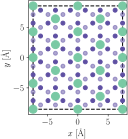

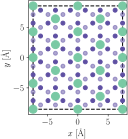

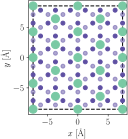

In [8]:
for sim in simulations:
    fix,ax = gt.plot_graphene_lattice_with_c_one_third(0.0,1.0001*L[sim][:-1])

### Investigate the layering in the z-direction

In [9]:
match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?')
δ,num_grid = {},{}
ρ,ρz = {},{}
aveN = {}
x,y,z = {},{},{}

for sim in simulations:
    try:
        with open(file_name[sim]['position'],'r') as inFile:
            est_info = inFile.readline()
            est_info = inFile.readline()
            print(est_info)
            nums = [x for x in re.findall(match_number, est_info)]
            δ[sim] = np.array([float(num) for num in nums[:3]])
            num_grid[sim] = int(nums[-1])

        # load the data
        ρ[sim] = np.loadtxt(file_name[sim]['position']).reshape([num_grid[sim],num_grid[sim],num_grid[sim]])
        aveN[sim] = np.sum(ρ[sim])*δ[sim][0]*δ[sim][1]*δ[sim][2]
        ρz[sim] = ρ[sim].sum(axis=(0,1))*δ[sim][0]*δ[sim][1]

        # get the spatial grid
        x[sim] = np.linspace(-L[sim][0]*0.5,L[sim][0]*0.5,num_grid[sim])
        y[sim] = np.linspace(-L[sim][1]*0.5,L[sim][1]*0.5,num_grid[sim])
        z[sim] = np.linspace(-L[sim][2]*0.5,L[sim][2]*0.5,num_grid[sim])

    except Exception as e:
        print('No Position Estimator!')
        print(e)

# ESTINF: dx = 2.893544E-01 dy = 3.341176E-01 dz = 1.960784E-01 NGRIDSEP = 51

# ESTINF: dx = 2.893544E-01 dy = 3.341176E-01 dz = 1.960784E-01 NGRIDSEP = 51

# ESTINF: dx = 2.893544E-01 dy = 3.341176E-01 dz = 9.901961E-02 NGRIDSEP = 51



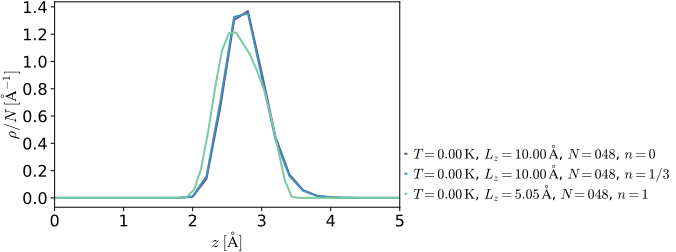

In [10]:
if ρz:
    with plt.style.context('../include/notebook.mplstyle'):
        for sim in simulations:
            plt.plot(z[sim]+L[sim][2]/2,ρz[sim]/(np.sum(ρz[sim])*δ[sim][2]), label=texformat(sim))

        plt.xlim(0,5)
        plt.xlabel(r'$z\; [\mathrm{\AA}]$')
        plt.ylabel(r'$\rho/N\; [\mathrm{\AA}^{-1}]$')
        plt.legend(loc=(1,0))
#plt.savefig('../plots/rho_z_first_layer.pdf',dpi=300)

## Now do this properly with the linear density

In [11]:
if reduce_data:
    for sim in simulations:
        if 'grand' in par_map[sim]['Ensemble']:
            !reduce-one.py -r T -L {L[sim][2]} -u {μ[sim]} -t {τ[sim]} -s {skip[sim]} -i {pimcid[sim]} --estimator=lineardensity  {base_dir[sim]}/
        else:
           !reduce-one.py -r T -N {N[sim]} -n {n[sim]} -t {τ[sim]} -s {skip[sim]} -i {pimcid[sim]} --canonical --estimator=lineardensity  {base_dir[sim]}/

Perform an integral of the full density data to make sure we get the correct planar density

In [12]:
ρ_lin,δρ_lin = {},{}
z_lin = {}
ave_N = {}
for sim in simulations:
    reduce_params = {'canonical':('canonical' == par_map[sim]['Ensemble']),'L':L[sim][2],'μ':μ[sim],'τ':τ[sim],'N':N[sim],'n':n[sim],
                    'pimcid':pimcid[sim],'base_dir':base_dir[sim],'reduce':'T'}

    z_lin[sim],ρ_lin[sim],δρ_lin[sim] = np.loadtxt(
        pimchelp.get_reduce_name(estimator='lineardensity',**reduce_params),unpack=True)

    ρ_lin[sim] *= L[sim][0]*L[sim][1]
    δρ_lin[sim] *= L[sim][0]*L[sim][1]
    ave_N[sim] = np.sum(ρ[sim])*δ[sim][0]*δ[sim][1]*δ[sim][2]

2.673267
2.673267
2.55


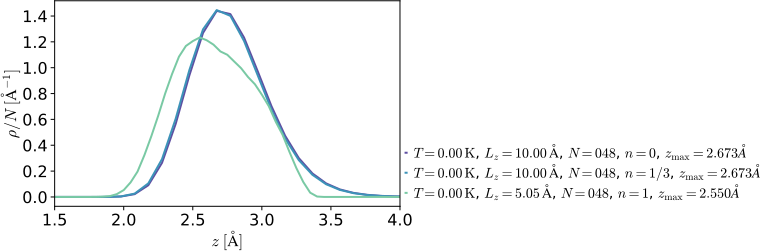

In [13]:
with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots()
    for sim in simulations:
        first_layer_id = np.argmax(ρ_lin[sim])
        z_max = z_lin[sim][first_layer_id]+L[sim][2]/2
        ax.plot(z_lin[sim]+L[sim][2]/2,ρ_lin[sim]/ave_N[sim], label=texformat(sim) + f', $z_\mathrm{{max}} = {z_max:.3f} Å$')

        print(z_max)

        #plt.plot(ρ_lin[id(1/3,40)][:,0]+L[id(1/3,40)][2]/2,ρ_lin[id(1/3,40)][:,1], label=f'$\mu = {μ[id(1/3,40)]}\ \mathrm{{K}}$')

    #print(z[fill][np.argmax(ρz[fill])]+L[fill][2]/2)
    #plt.text(0.99,0.9,f'$z_\mathrm{{max}} = {z_max:.3f} Å$', fontsize=18,transform=ax.transAxes, ha='right')
    ax.set_xlim(1.5,4)
    ax.set_xlabel(r'$z\; [\mathrm{\AA}]$')
    ax.set_ylabel(r'$\rho/N\; [\mathrm{\AA}^{-1}]$')
    ax.legend(loc=(1,0))
    #plt.savefig('./plots/rho_z_first_layer.png',dpi=300, facecolor='white')

## Planar Density

We compute the planar density via two possible methods based on which files are available

In [14]:
match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?')
δ_xy,num_grid_xy = {},{}
ρxy = {}
x_2D,y_2D = {},{}
for sim in simulations:
    try:
        with open(file_name[sim]['planeavedensity'],'r') as inFile:
            est_info = inFile.readline()
            #est_info = inFile.readline()
            print(est_info)
            nums = [x for x in re.findall(match_number, est_info)]
            δ_xy[sim] = np.array([float(num) for num in nums[:2]])
            num_grid_xy[sim] = int(nums[-1])
            
        ρxy[sim] = np.loadtxt(file_name[sim]['planeavedensity']).reshape([num_grid_xy[sim],num_grid_xy[sim]])
       
        x_2D[sim] = np.arange(-L[sim][0]*0.5,L[sim][0]*0.5-0.001,δ_xy[sim][0])
        y_2D[sim] = np.arange(-L[sim][1]*0.5,L[sim][1]*0.5-0.001,δ_xy[sim][0])
    except:
        ρxy[sim] = ρ[sim].sum(axis=2)*δ[sim][2]
        print(f'{sim}: Used integrated position for xy density!')

# ESTINF: dx = 7.198572E-02 dy = 8.312195E-02 NGRIDSEP = 205

# ESTINF: dx = 7.198572E-02 dy = 8.312195E-02 NGRIDSEP = 205

# ESTINF: dx = 7.198572E-02 dy = 8.312195E-02 NGRIDSEP = 205



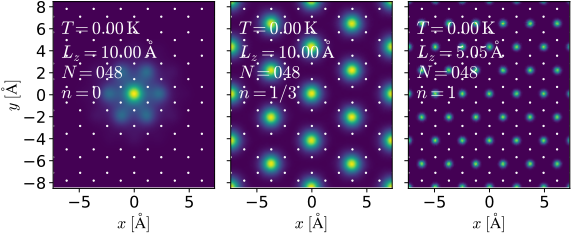

In [15]:
with plt.style.context(plot_style['notebook']):

    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=1,ncols=len(simulations),sharex=True, sharey=True,
                          figsize=(len(simulations)/2*figsize[0],figsize[1]),squeeze=False)
    fig.subplots_adjust(wspace=0.1)
    for i,sim in enumerate(simulations):

        c_positions = np.vstack(gt.get_graphene_carbon_atoms(0.0,L[sim][:-1]))
        ax[0,i].scatter(c_positions[:,0],c_positions[:,1], s=2, c='w')
        ax[0,i].imshow(ρxy[sim].T,aspect='equal',
                       extent=[np.min(x_2D[sim]),np.max(x_2D[sim]),np.min(y_2D[sim]),np.max(y_2D[sim])],
                       cmap='viridis', rasterized=True, origin='lower')
        
        #ax[0,i].scatter(-np.sqrt(3)*1.42/2,-3*1.42/2,s=10, c='pink')
        #ax[0,i].annotate(f'$\mu = {float(μ[sim]):.1f}\ \mathrm{{K}}$', xy=(0.05,0.9),xytext=(0.05, 0.9), 
        #               textcoords='axes fraction', color='white', fontsize=18)
        ax[0,i].annotate(texformat(sim,split_lines=True), xy=(0.05,0.9),xytext=(0.05, 0.9), 
                       textcoords='axes fraction', color='white', va='top',fontsize=18)

        ax[0,i].set_xlabel(r'$x\; [\mathrm{\AA}]$')
    ax[0,0].set_ylabel(r'$y\; [\mathrm{\AA}]$');
    #plt.savefig('./plots/isotropic_graphene_density.png', dpi=300, facecolor='white')

## Plot a cut at $y=0$

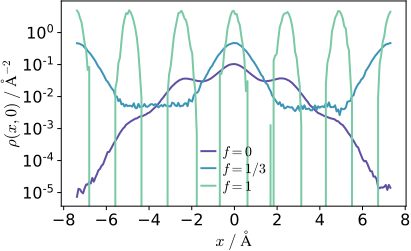

In [16]:
with plt.style.context(plot_style['notebook']):

    for sim in simulations:
        plt.semilogy(x_2D[sim],ρxy[sim].T[102,:]*L[sim][-1], label=f"$f={vals(sim)['n']}$")

    plt.legend(handlelength=1)
    plt.xlabel(r'$x \; / \; \mathrm{\AA}$')
    plt.ylabel(r'$\rho(x,0) \; / \; \mathrm{\AA}^{-2}$')

## Plot the Density at 1/3 Filling Showing $V^\prime$

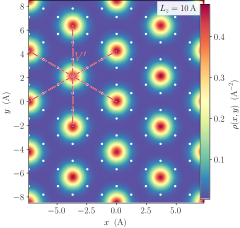

In [17]:
import matplotlib.patheffects as path_effects
with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize']
    plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

    fig,ax = plt.subplots(nrows=1,ncols=1,sharex=True, sharey=True,
                          figsize=(figsize[0],1.3*figsize[0]),squeeze=False, constrained_layout=True)
    sim = lab(n=1/3,Lz=10,N=48,T=0)
    c_positions = np.vstack(gt.get_graphene_carbon_atoms(0.0,L[sim][:-1]))
    ax[0,0].scatter(c_positions[:,0],c_positions[:,1], s=2, c='w')
    im = ax[0,0].imshow(ρxy[sim].T*L[sim][-1],aspect='equal',
                    extent=[np.min(x_2D[sim]),np.max(x_2D[sim]),np.min(y_2D[sim]),np.max(y_2D[sim])],
                    cmap='Spectral_r', rasterized=True, origin='lower', interpolation='lanczos')
        
        #ax[0,i].scatter(-np.sqrt(3)*1.42/2,-3*1.42/2,s=10, c='pink')
        #ax[0,i].annotate(f'$\mu = {float(μ[sim]):.1f}\ \mathrm{{K}}$', xy=(0.05,0.9),xytext=(0.05, 0.9), 
        #               textcoords='axes fraction', color='white', fontsize=18)
        #ax[0,i].annotate(texformat(sim,split_lines=True), xy=(0.05,0.9),xytext=(0.05, 0.9), 
        #               textcoords='axes fraction', color='white', va='top',fontsize=18)

    ax[0,0].set_xlabel(r'$\alabel{x}{\angstrom}$');
    ax[0,0].set_ylabel(r'$\alabel{y}{\angstrom}$');
    ax[0,0].text(0.98,0.985,r'$L_z = \SI{10}{\angstrom}$', fontsize=9, ha='right',va='top',
              transform=ax[0,0].transAxes, 
               bbox=dict(facecolor='w',alpha=0.9, pad=2.5, edgecolor='None'))
    
    θ = π/6
    aₒ = 1.42
    a = (aₒ/2)*np.array([[np.sqrt(3),-np.sqrt(3)],[3,3]])
    R = np.array([[np.cos(θ),-np.sin(θ)],[np.sin(θ),np.cos(θ)]])
    α = np.matmul(R,np.sqrt(3)*a)
    
    shift = 0
    r0 = α[0,1]+shift*np.sqrt(3)*aₒ, α[1,1] 
    nn_bonds = [[r0[0],r0[0]+α[0,1],r0[1],r0[1]+α[1,1]],
                [r0[0],r0[0],r0[1],r0[1]+α[1,0]],
                [r0[0],r0[0]-α[0,1],r0[1],r0[1]+α[1,1]],
                [r0[0],r0[0]-α[0,1],r0[1],r0[1]-α[1,1]],
                [r0[0],r0[0],r0[1],r0[1]-α[1,0]],
                [r0[0],r0[0]+α[0,1],r0[1],r0[1]-α[1,1]]
               ]
    for cnn in nn_bonds:
        ax[0,0].plot([cnn[0],cnn[1]],[cnn[2],cnn[3]], ls='--', color='#d43e4e', lw=1, 
           zorder=10,dashes=(8, 2),
                     path_effects=[path_effects.SimpleLineShadow(offset=(0.0, -0.0),linewidth=1.2, alpha=1,
                                                                 shadow_color='w'),path_effects.Normal()])
  
    ax[0,0].annotate(r'$V^\prime$', xy=(α[0,1]+0.1+shift*np.sqrt(3)*aₒ,α[1,0]-0.1), 
                     xytext=(α[0,1]+0.1+shift*np.sqrt(3)*aₒ,α[1,0]-0.1), ha='left', va='top',
                fontsize=12, color='#d43e4e', 
                path_effects=[path_effects.withSimplePatchShadow(offset=(0.3, -0.3), shadow_rgbFace='white', alpha=0.75)])

    ax[0,0].set_xlim(np.min(x_2D[sim]),np.max(x_2D[sim]))
    
    fig.colorbar(im, ax=ax[0,0], shrink=0.625,pad=-0.02, label=r'$\alabel{\rho(x,y)}{\angstrom^{-2}}$')

    plt.savefig('../plots/density_n_1o3_NA_48.pdf')
    plt.savefig('../plots/density_n_1o3_NA_48.svg')

## Plot the density at unit filling showing $V$ and $V^\prime$

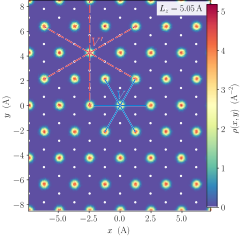

In [18]:
with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize']
    plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

    fig,ax = plt.subplots(nrows=1,ncols=1,sharex=True, sharey=True,
                          figsize=(figsize[0],1.3*figsize[0]),squeeze=False, constrained_layout=True)
    sim = lab(n=1,Lz=5.05,N=48,T=0)
    c_positions = np.vstack(gt.get_graphene_carbon_atoms(0.0,L[sim][:-1]))
    ax[0,0].scatter(c_positions[:,0],c_positions[:,1], s=2, c='w')
    im = ax[0,0].imshow(ρxy[sim].T*L[sim][-1],aspect='equal',
                    extent=[np.min(x_2D[sim]),np.max(x_2D[sim]),np.min(y_2D[sim]),np.max(y_2D[sim])],
                    cmap='Spectral_r', rasterized=True, origin='lower', interpolation='lanczos')
        
        #ax[0,i].scatter(-np.sqrt(3)*1.42/2,-3*1.42/2,s=10, c='pink')
        #ax[0,i].annotate(f'$\mu = {float(μ[sim]):.1f}\ \mathrm{{K}}$', xy=(0.05,0.9),xytext=(0.05, 0.9), 
        #               textcoords='axes fraction', color='white', fontsize=18)
        #ax[0,i].annotate(texformat(sim,split_lines=True), xy=(0.05,0.9),xytext=(0.05, 0.9), 
        #               textcoords='axes fraction', color='white', va='top',fontsize=18)

    ax[0,0].set_xlabel(r'$\alabel{x}{\angstrom}$');
    ax[0,0].set_ylabel(r'$\alabel{y}{\angstrom}$');
    ax[0,0].text(0.98,0.985,r'$L_z = \SI{5.05}{\angstrom}$', fontsize=9, ha='right',va='top',
              transform=ax[0,0].transAxes, 
               bbox=dict(facecolor='w',alpha=0.9, pad=2.5, edgecolor='None'))
    
    θ = π/6
    aₒ = 1.42
    a = (aₒ/2)*np.array([[np.sqrt(3),-np.sqrt(3)],[3,3]])
    R = np.array([[np.cos(θ),-np.sin(θ)],[np.sin(θ),np.cos(θ)]])
    α = np.matmul(R,np.sqrt(3)*a)
    
    shift = 0.5
    r0 = α[0,1]+np.sqrt(3)*aₒ/2, 2*α[1,1] 
    nn_bonds = [[r0[0],r0[0]+α[0,1],r0[1],r0[1]+α[1,1]],
                [r0[0],r0[0],r0[1],r0[1]+α[1,0]],
                [r0[0],r0[0]-α[0,1],r0[1],r0[1]+α[1,1]],
                [r0[0],r0[0]-α[0,1],r0[1],r0[1]-α[1,1]],
                [r0[0],r0[0],r0[1],r0[1]-α[1,0]],
                [r0[0],r0[0]+α[0,1],r0[1],r0[1]-α[1,1]]
               ]
    for cnn in nn_bonds:
        ax[0,0].plot([cnn[0],cnn[1]],[cnn[2],cnn[3]], ls='--', color='#d43e4e', lw=1, 
           zorder=10,dashes=(8, 2),
                     path_effects=[path_effects.SimpleLineShadow(offset=(0.0, -0.0),linewidth=1.2, alpha=1,
                                                                 shadow_color='w'),path_effects.Normal()])    
                     
                    # path_effects=[path_effects.SimpleLineShadow(offset=(0.5, -0.5)),
                    #   path_effects.Normal()])
            
    r0 = 0,0 
    nn_bonds = [[r0[0],r0[0]+a[0,1],r0[1],r0[1]+a[1,1]],
                [r0[0],r0[0]+a[1,0],r0[1],r0[1]],
                [r0[0],r0[0]-a[0,1],r0[1],r0[1]+a[1,1]],
                [r0[0],r0[0]-a[0,1],r0[1],r0[1]-a[1,1]],
                [r0[0],r0[0]-a[1,0],r0[1],r0[1]],
                [r0[0],r0[0]+a[0,1],r0[1],r0[1]-a[1,1]]
               ]
    for cnn in nn_bonds:
        ax[0,0].plot([cnn[0],cnn[1]],[cnn[2],cnn[3]], ls='-', color='#0173cd', lw=1, 
           zorder=10,dashes=(8, 0),
                     path_effects=[path_effects.SimpleLineShadow(offset=(0.0, -0.0),linewidth=1.2, alpha=1,
                                                                 shadow_color='w'),path_effects.Normal()])
                     
#                      path_effects=[path_effects.SimpleLineShadow(offset=(0.5, -0.5)),
#                        path_effects.Normal()])
        
    ax[0,0].annotate(r'$V^\prime$', xy=(α[0,1]+0.1+shift*np.sqrt(3)*aₒ,α[1,0]+1.25), 
                     xytext=(α[0,1]+0.1+shift*np.sqrt(3)*aₒ,α[1,0]+1.25), ha='left', va='top',
                fontsize=12, color='#d43e4e',
                     path_effects=[path_effects.withSimplePatchShadow(offset=(0.3, -0.3), 
                                                                      shadow_rgbFace='white', alpha=0.75)])

    
    ax[0,0].annotate(r'$V$', xy=(-0.05,0.8), ha='center', va='center',fontsize=12, 
                     color='#0173cd',
                     path_effects=[path_effects.withSimplePatchShadow(offset=(0.3, -0.3), 
                                                                      shadow_rgbFace='white', alpha=0.75)])


    
    ax[0,0].set_xlim(np.min(x_2D[sim]),np.max(x_2D[sim]))
    ax[0,0].set_ylim(np.min(y_2D[sim]),np.max(y_2D[sim]))

    
    fig.colorbar(im, ax=ax[0,0], shrink=0.65,pad=-0.02, label=r'$\alabel{\rho(x,y)}{\angstrom^{-2}}$')

    plt.savefig('../plots/density_n_1_NA_48.pdf')
    plt.savefig('../plots/density_n_1_NA_48.svg')

### A zoomed-in version

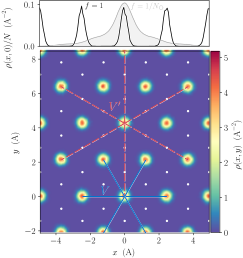

In [54]:
from matplotlib import gridspec
with plt.style.context(plot_style['aps']):
    figsize = plt.rcParams['figure.figsize']
    plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

#     fig,ax = plt.subplots(nrows=1,ncols=1,sharex=True, sharey=True,
#                           figsize=(figsize[0],1.3*figsize[0]),squeeze=False, constrained_layout=True)
    
    fig = plt.figure(figsize=(figsize[0],1.05*figsize[0]),constrained_layout=True) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4], width_ratios=[1], figure=fig) 
   
    # plot a cut at x=0
    ax0 = plt.subplot(gs[0])
    ax0.xaxis.set_visible(False)
    aveρxy = (ρxy[sim].T[0,:] + ρxy[sim].T[102,:] + ρxy[sim].T[-1,:])/3
    ax0.plot(x_2D[sim],aveρxy*L[sim][-1]/N[sim], color='k', lw=0.75, label='$f=1$', 
            path_effects=[path_effects.SimpleLineShadow(offset=(0.0, 0.0), linewidth=2, alpha=1,shadow_color='w'),
                       path_effects.Normal()])
    
    # plot the single-particle density
    pimc_x,pimc_ρ = np.loadtxt("../data/wannier_cut.txt", usecols=(2,3), unpack=True)
    pimc_Lz = 10.0
    
    ax0.plot(pimc_x[:205],pimc_ρ[:205], color='gray', lw=0.5, label='$f=1/N_{\graphene}$', 
             zorder=-10, alpha=0.75)
    
    ax0.fill_between(pimc_x[:205],pimc_ρ[:205], color='gray', alpha=0.1, zorder=-20)
    ax0.set_xlim(-2*np.sqrt(3)*aₒ,2*np.sqrt(3)*aₒ)
    #ax0.legend(handlelength=0.5)
    
    ax0.set_ylabel(r'$\alabel{\rho(x,0)/N}{\angstrom^{-2}}$')

    
    ax1 = plt.subplot(gs[1])
    sim = lab(n=1,Lz=5.05,N=48,T=0)
    
    c_positions = np.vstack(gt.get_graphene_carbon_atoms(0.0,L[sim][:-1]))
    ax1.scatter(c_positions[:,0],c_positions[:,1], s=2, c='w')
    im = ax1.imshow(ρxy[sim].T*L[sim][-1],aspect='equal',
                    extent=[np.min(x_2D[sim]),np.max(x_2D[sim]),np.min(y_2D[sim]),np.max(y_2D[sim])],
                    cmap='Spectral_r', rasterized=True, origin='lower', interpolation='bicubic')
        
    ax1.set_xlabel(r'$\alabel{x}{\angstrom}$');
    ax1.set_ylabel(r'$\alabel{y}{\angstrom}$');

    θ = π/6
    aₒ = 1.42
    a = (aₒ/2)*np.array([[np.sqrt(3),-np.sqrt(3)],[3,3]])
    R = np.array([[np.cos(θ),-np.sin(θ)],[np.sin(θ),np.cos(θ)]])
    α = np.matmul(R,np.sqrt(3)*a)
    
    shift = 0.5
    r0 = α[0,1]+3*np.sqrt(3)*aₒ/2, 2*α[1,1] 
    nn_bonds = [[r0[0],r0[0]+α[0,1],r0[1],r0[1]+α[1,1]],
                [r0[0],r0[0],r0[1],r0[1]+α[1,0]],
                [r0[0],r0[0]-α[0,1],r0[1],r0[1]+α[1,1]],
                [r0[0],r0[0]-α[0,1],r0[1],r0[1]-α[1,1]],
                [r0[0],r0[0],r0[1],r0[1]-α[1,0]],
                [r0[0],r0[0]+α[0,1],r0[1],r0[1]-α[1,1]]
               ]
    for cnn in nn_bonds:
        ax1.plot([cnn[0],cnn[1]],[cnn[2],cnn[3]], ls='--', color='#d43e4e', lw=1, 
           zorder=10,dashes=(8, 2),path_effects=[path_effects.SimpleLineShadow(offset=(0.3, -0.3), alpha=0.75, shadow_color='w'),
                       path_effects.Normal()])
            
    r0 = 0,0 
    nn_bonds = [[r0[0],r0[0]+a[0,1],r0[1],r0[1]+a[1,1]],
                [r0[0],r0[0]+np.sqrt(3)*aₒ,r0[1],r0[1]],
                [r0[0],r0[0]-a[0,1],r0[1],r0[1]+a[1,1]],
                [r0[0],r0[0]-a[0,1],r0[1],r0[1]-a[1,1]],
                [r0[0],r0[0]-np.sqrt(3)*aₒ,r0[1],r0[1]],
                [r0[0],r0[0]+a[0,1],r0[1],r0[1]-a[1,1]]
               ]
    for cnn in nn_bonds:
        ax1.plot([cnn[0],cnn[1]],[cnn[2],cnn[3]], ls='-', color='#0173cd', lw=1, 
           zorder=10,dashes=(8, 0),path_effects=[path_effects.SimpleLineShadow(offset=(0.3, -0.3), alpha=0.75,shadow_color='w'),
                       path_effects.Normal()])
        
    ax1.annotate(r'$V^\prime$', xy=(-0.95,5.5), 
                     ha='left', va='top',
                fontsize=12, color='#d43e4e',
                     path_effects=[path_effects.withSimplePatchShadow(offset=(0.3, -0.3), shadow_rgbFace='white', alpha=0.75)])
    
    ax1.annotate(r'$V$', xy=(-np.sqrt(3)*aₒ/2,0.3), ha='center', va='center',fontsize=12, 
                     color='#0173cd',
                     path_effects=[path_effects.withSimplePatchShadow(offset=(0.3, -0.3), shadow_rgbFace='white', alpha=0.75)])

    
    ax1.set_xlim(-2*np.sqrt(3)*aₒ,2*np.sqrt(3)*aₒ)
    ax1.set_ylim(-3/2*aₒ,np.max(y_2D[sim]))
    
    fig.colorbar(im, ax=ax1, shrink=0.995,pad=0.01, label=r'$\alabel{\rho(x,y)}{\angstrom^{-2}}$')
    fig.set_constrained_layout_pads(w_pad=1.5/72, h_pad=0, hspace=-0.553, wspace=0)    
    ax0.yaxis.set_label_coords(-0.12,0.4)
    ax1.yaxis.set_label_coords(-0.12,0.5)

    ax0.annotate(r'$f=1/N_{\graphene}$', xy=(0.35,0.105), ha='left', va='top',
                fontsize=8, color='gray', alpha=0.5, rotation=0)
    ax0.annotate(r'$f=1$', xy=(-2.3,0.105), ha='left', va='top',
                fontsize=8, color='k', rotation=0)
    #ax0.annotate(r'$y=0$', xy=(-4,0.105), ha='center', va='top')
    ax0.set_ylim(bottom=0)

    ax0.yaxis.set_label_coords(-0.16,0.25)
    plt.savefig('../plots/density_n_1_NA_48_zoom.pdf')

In [157]:
np.average([1/0.021, 1/0.025, 1/0.051, 1/0.011])

49.53399541634836

In [51]:
np.sqrt(3)*aₒ/2

1.2297560733739028

In [49]:
a[0,1]

-1.2297560733739028

In [20]:
for sim in simulations:
    print('\n',sim)
    %run $script_dir/pimcave.py {file_name[sim]['estimator']}


 T = 0.00 K, Lz = 10.00 Å, N = 048, n = 0
# PIMCID bd2086cd-a475-4b84-9561-c51a029fbf95
# Number Samples  79944
K                   23.98172	     0.04133	 0.17
V                 -145.95400	     0.00899	 0.01
V_ext             -145.91394	     0.00896	 0.01
V_int                0.00000	     0.00000	 0.00
E                 -121.97228	     0.04033	 0.03
E_mu              -121.97228	     0.04033	 0.03
K/N                 23.98172	     0.04133	 0.17
V/N               -145.95400	     0.00899	 0.01
E/N               -121.97228	     0.04033	 0.03

 T = 0.00 K, Lz = 10.00 Å, N = 048, n = 1/3
# PIMCID 1e28c026-d6b4-4615-b6dc-4c8afb2e16e5
# Number Samples   2200
K                  502.58486	     1.38257	 0.28
V                -2489.82510	     0.36294	 0.01
V_ext            -2357.95194	     0.35251	 0.01
V_int             -130.34724	     0.06243	 0.05
E                -1987.24025	     1.38382	 0.07
E_mu             -1987.24025	     1.38382	 0.07
K/N                 31.41155	     0.08641	 0.28
V/N 

<Figure size 245.081x151.469 with 0 Axes>

### Let's check the number of particles

In [19]:
for sim in simulations:
    print(sim,np.sum(ρxy[sim])*δ_xy[sim][0]*δ_xy[sim][1]*L[sim][2])
    print(sim,np.sum(ρ[sim])*δ[sim][0]*δ[sim][1]*δ[sim][2])

T = 0.00 K, Lz = 10.00 Å, N = 048, n = 0 0.9999999663059417
T = 0.00 K, Lz = 10.00 Å, N = 048, n = 0 0.9999998021003852
T = 0.00 K, Lz = 10.00 Å, N = 048, n = 1/3 15.9999994613971
T = 0.00 K, Lz = 10.00 Å, N = 048, n = 1/3 15.999996834469668
T = 0.00 K, Lz = 5.05 Å, N = 048, n = 1 47.999997994582436
T = 0.00 K, Lz = 5.05 Å, N = 048, n = 1 47.99999883759534
